In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.image_rendering_data_module import ImageRenderingDataModule
from imap.model.nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from imap.utils.torch_math import *

# Load images

In [4]:
color_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/1305031467.695886.png"))
depth_image_path = str(Path("../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/1305031464.952471.png"))

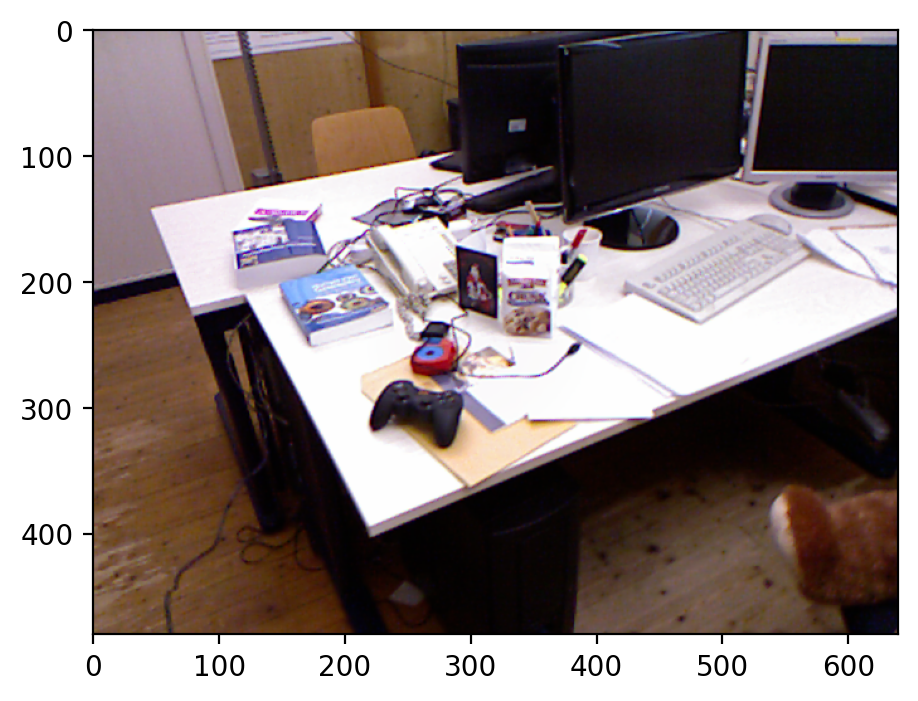

In [5]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

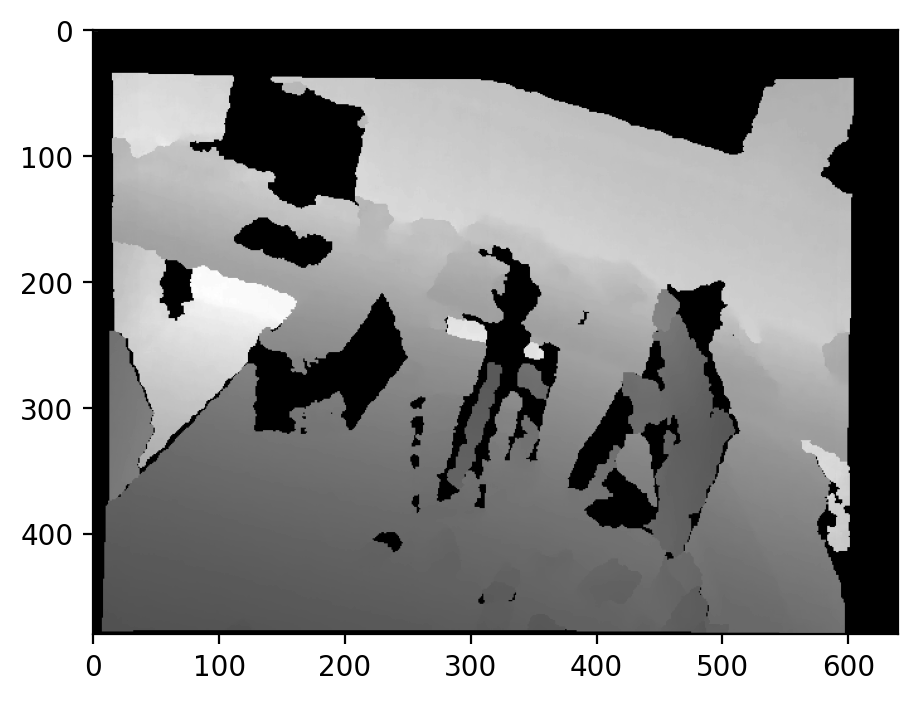

In [6]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 5000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

In [131]:
dataset_params = {'dataset_path': "../test_datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
#                   'frame_indices': [131, 325],
#                   'frame_indices': [325],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)

Reading ../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [124]:
data_module._dataset._positions[0]

array([[ 0.99142617,  0.11844859,  0.05517276,  0.02306   ],
       [ 0.03231489, -0.6313777 ,  0.7748019 , -0.03236   ],
       [ 0.12660904, -0.766376  , -0.62979203,  0.16913001],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [35]:
data_module.train_dataloader()

In [29]:
for d in data_module.train_dataloader():
    print(d['pixel'])
    print(d['camera_position'])
    print(d['camera_position'].shape)
    break

hello
1 5
hello
2 5
tensor([[134., 141.],
        [237., 284.],
        [192.,  36.],
        ...,
        [157., 163.],
        [135., 404.],
        [364., 440.]])
tensor([[[ 0.9914,  0.1184,  0.0552,  0.0231],
         [ 0.0323, -0.6314,  0.7748, -0.0324],
         [ 0.1266, -0.7664, -0.6298,  0.1691],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9914,  0.1184,  0.0552,  0.0231],
         [ 0.0323, -0.6314,  0.7748, -0.0324],
         [ 0.1266, -0.7664, -0.6298,  0.1691],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9914,  0.1184,  0.0552,  0.0231],
         [ 0.0323, -0.6314,  0.7748, -0.0324],
         [ 0.1266, -0.7664, -0.6298,  0.1691],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        ...,

        [[ 0.5953, -0.6495,  0.4731, -0.0698],
         [-0.8026, -0.5079,  0.3128,  0.0192],
         [ 0.0371, -0.5659, -0.8236,  0.1275],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.5953, -0.6495,  0.4731, -0.0698],
         [-0.

In [18]:
def invert_position(matrix):
    result = np.zeros((3, 4))
    result[:3, :3] = matrix[:3, :3].T
    result[:3, 3:4] = -matrix[:3, :3].T @ matrix[:3, 3:4]
    return result

In [19]:
def get_point_cloud(index, scale=5):
    y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
    int_pixels = (np.array([x, y], dtype=np.int32).T * scale).reshape(-1, 2)
    depths = torch.tensor(data_module._dataset._depth_images[index][int_pixels[:, 1], int_pixels[:, 0]]).float()
    pixels = torch.tensor(int_pixels.astype(np.float32))
    position = data_module._dataset._positions[index]
#     position = invert_position(position)
    position = torch.repeat_interleave(
        torch.tensor(position.astype(np.float32))[None], depths.shape[0], dim=0)
    inverted_camera_matrix = torch.tensor(
        data_module._dataset._camera_info.get_inverted_camera_matrix().astype(np.float32))
    return back_project_pixel(pixels, depths, position, inverted_camera_matrix).cpu().detach().numpy()

In [20]:
points0 = get_point_cloud(0)
points1 = get_point_cloud(3)

In [21]:
# fig = go.Figure(
#     data=[
#         go.Scatter3d(x=points0[:, 0],
#                      y=points0[:, 1], 
#                      z=points0[:, 2],
#                      mode="markers",
#                      name="0",
#                      marker={
#                          "size": 2
#                      }),
#                 go.Scatter3d(x=points1[:, 0],
#                      y=points1[:, 1], 
#                      z=points1[:, 2],
#                      mode="markers",
#                      name="0",
#                      marker={
#                          "size": 2
#                      }),
#     ]
# )
# fig.show()

# Make model

In [36]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())

In [37]:
# logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
logger_path = os.path.join("lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 5,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
# task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name="chess"),
    callbacks=[],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [39]:
trainer.fit(model, data_module);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _mlp                 | MLP                        | 246 K 
1 | _positional_encoding | GaussianPositionalEncoding | 279   
2 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.986     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [13]:
# torch.save(model.state_dict(), "test_l1.pth");

In [14]:
# model.load_state_dict(torch.load("test_l1.pth"))

# New architecture

In [4]:
from IPython.display import clear_output

In [5]:
from imap.trainers.trainers import ModelTrainer, ClassicalModelTrainer, ModelTrainer2

In [6]:
dataset_params = {'dataset_path': "../test_datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
#                   'frame_indices': [131, 325],
#                   'frame_indices': [325],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
# dataset_params=1
data_module = ImageRenderingDataModule('tum', **dataset_params)
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(lr=0.005),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    encoding_sigma=25,
    optimize_positions=False,
    minimal_depth=0.01
)
factory = UniversalFactory([NERF])


Reading ../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt
Read (5, 480, 640, 3) images array
Dataset size: 1536000 pixels
[ToyDataModule] - train subset size 1536000


In [65]:
# Training on the same dataset as it was before
# model_classical_training = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())
# trainer = ClassicalModelTrainer(model_classical_training)
# for i in range(5):
#     for j, batch in enumerate(data_module.train_dataloader()):
#         loss = trainer.train(model_classical_training, batch)
#         if j % 5 == 0:
#             print(f"loss {loss}")
    

loss 3.188734531402588
loss 1.7735111713409424
loss 2.3119635581970215
loss 1.489565134048462
loss 1.5134012699127197
loss 1.5595263242721558
loss 1.286972165107727
loss 1.2505990266799927
loss 1.182000756263733
loss 1.178916335105896
loss 1.1376471519470215
loss 1.0852051973342896
loss 1.0804219245910645
loss 1.0275095701217651
loss 0.9810763001441956
loss 1.102553129196167
loss 1.0051127672195435
loss 0.9909003376960754
loss 1.066540002822876
loss 0.9391791820526123
loss 0.8624095916748047
loss 0.9883748292922974
loss 0.9262493848800659
loss 0.9024871587753296
loss 0.9136836528778076
loss 0.9119343161582947
loss 0.8577386140823364
loss 0.9612677693367004
loss 0.8988291025161743
loss 0.8039486408233643
loss 0.8654520511627197
loss 0.8385995626449585
loss 0.8191794157028198
loss 0.897524356842041
loss 0.7781098484992981
loss 0.8523992300033569
loss 0.885137677192688
loss 0.7614364624023438
loss 0.7574355006217957
loss 0.840114176273346
loss 0.6895611882209778
loss 0.6903194189071655
lo

In [ ]:

# trainer = ModelTrainer()
# for i in range(1):
#     clear_output(wait=True)
#     trainer.train(model2, data_module.train_dataloader())
# torch.cuda.empty_cache()

In [196]:
for s in model_buffer_input:
    print(s['camera_position'])

tensor([[ 0.5953, -0.6495,  0.4731, -0.0698],
        [-0.8026, -0.5079,  0.3128,  0.0192],
        [ 0.0371, -0.5659, -0.8236,  0.1275],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.9397,  0.3413, -0.0200,  0.0041],
        [ 0.1840, -0.4555,  0.8710, -0.0378],
        [ 0.2881, -0.8222, -0.4909,  0.1868],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.4879,  0.4318, -0.7586,  0.1705],
        [ 0.8725, -0.2686,  0.4083, -0.0167],
        [-0.0274, -0.8611, -0.5078,  0.1448],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.3133,  0.6762, -0.6668,  0.1371],
        [ 0.9435, -0.1418,  0.2996,  0.0472],
        [ 0.1080, -0.7230, -0.6824,  0.1659],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [250]:
for color_image, depth_image, position in tum_dataset_loader:
        print('====')
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        position = camera.process_positions(position)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, position)
        model_buffer_input.update_data(state)
        break
        
# s1 = next(model_buffer_input)

====
[[ 0.99142617  0.11844859  0.05517276  0.02306   ]
 [ 0.03231489 -0.6313777   0.7748019  -0.03236   ]
 [ 0.12660904 -0.766376   -0.62979203  0.16913001]
 [ 0.          0.          0.          1.        ]]


In [253]:
model_buffer_input._states[0].frame.color_image[0,0]

array([0.41015625, 0.109375  , 0.328125  ], dtype=float32)

In [237]:
data_module._dataset._color_images[0,0,0]

array([0.41015625, 0.109375  , 0.328125  ], dtype=float32)

In [254]:
# model_buffer_input._states[0].position
s1 = next(model_buffer_input)
s1['camera_position']

tensor([[ 0.9914,  0.1184,  0.0552,  0.0231],
        [ 0.0323, -0.6314,  0.7748, -0.0324],
        [ 0.1266, -0.7664, -0.6298,  0.1691],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [148]:
s1['camera_position']

tensor([[ 0.5953, -0.6495,  0.4731, -0.6976],
        [-0.8026, -0.5079,  0.3128,  0.1923],
        [ 0.0371, -0.5659, -0.8236,  1.2751],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [261]:
data_module._dataset._color_images[0, 313, 566]

array([0.9921875, 0.9921875, 0.9921875], dtype=float32)

In [266]:
data_module._dataset._depth_images[0, 313, 566]

0.13889197

In [258]:
s1['pixel'].numpy().astype(int)

array([[566, 313],
       [516,  28],
       [420,  94],
       ...,
       [ 73, 294],
       [232, 149],
       [336, 407]])

In [262]:
s1['color']

tensor([[0.9922, 0.9922, 0.9922],
        [0.7148, 0.6992, 0.7539],
        [0.4531, 0.3281, 0.3086],
        ...,
        [0.9336, 0.9219, 0.9492],
        [0.0820, 0.0430, 0.0703],
        [0.2617, 0.3750, 0.4844]])

In [263]:
s1['depth']

tensor([0.1389, 0.0000, 0.0000,  ..., 0.1315, 0.0000, 0.1149])

In [21]:
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.model_buffer_input import ModelBufferInput
from imap.model.primitives import State, Frame

new_model = factory.make_from_parameters(parameters, camera_info=data_module.camera_info())
camera, tum_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

model_buffer_input = ModelBufferInput(points_per_frame= int(640*460/100))
trainer = ModelTrainer(new_model)

for i in tqdm(range(2000)):
    for color_image, depth_image, position in tum_dataset_loader:
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        position = camera.process_positions(position)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, position)
        model_buffer_input.update_data(state)


    for batch in model_buffer_input:
        
        loss = trainer.train(new_model, batch)
    # trainer.reset_params()
    
    if i%5 == 0:
        print(f"loss {loss}")
    # clear_output(wait=True)
    
torch.cuda.empty_cache()

Reading ../test_datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


  0%|          | 0/2000 [00:00<?, ?it/s]

loss 2.0768330097198486
loss 1.7820192575454712
loss 1.2314395904541016
loss 1.080277681350708
loss 0.92090904712677
loss 0.9170470833778381
loss 0.9376575946807861
loss 0.8392614722251892
loss 0.861116349697113
loss 0.7810665965080261
loss 0.8149732947349548
loss 0.7558722496032715
loss 0.7280523777008057
loss 0.7172955274581909
loss 0.7047440409660339
loss 0.7603905200958252
loss 0.7078298330307007
loss 0.6608701944351196
loss 0.6142967343330383
loss 0.7160381078720093
loss 0.821631908416748
loss 0.5992142558097839
loss 0.6423225402832031
loss 0.6533441543579102
loss 0.6566110253334045
loss 0.6055014133453369
loss 0.6875951886177063
loss 0.6467039585113525
loss 0.6721161007881165
loss 0.6024408936500549
loss 0.6337103247642517
loss 0.6151636242866516
loss 0.5963727235794067
loss 0.6438167691230774
loss 0.5879814624786377
loss 0.6227737069129944
loss 0.6270297765731812
loss 0.6381382346153259
loss 0.5714680552482605
loss 0.5562453866004944
loss 0.6139309406280518
loss 0.59513503313064

# Show the results

In [9]:
from scipy.spatial.transform import Rotation

In [10]:
def get_position(translation, rotation):
    matrix_position = np.eye(4)
    matrix_position[:3, 3] = translation
    matrix_position[:3, :3] = Rotation.from_euler("xyz", rotation).as_matrix()
    return matrix_position

In [11]:
scale = 1
y, x = np.meshgrid(range(color_image.shape[0] // scale), range(color_image.shape[1] // scale))                       
pixels = np.array([x, y], dtype=np.float32).T * scale
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
# position = get_position(np.array([0, 0, 0]), np.array([0, 0, 0]))
position = data_module._dataset._positions[3]
# delta_position = get_position(np.array([0, 0, 0.5]), np.array([0, 0, 0]))
# position = get_position(np.array([0.013575  , -0.03508   ,  0.17796502]), 
#                           np.array([-2.18386447, -0.20961459,  0.11297752]))
# delta_position = get_position(np.array([0, 0, -0.05]), np.array([0, -0.3, 0]))
# position =  position @ delta_position
positions = torch.repeat_interleave(torch.tensor(position.astype(np.float32))[None], pixels.shape[0],
                                  dim=0).cuda()

In [43]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
model = model.cuda()
model.eval()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

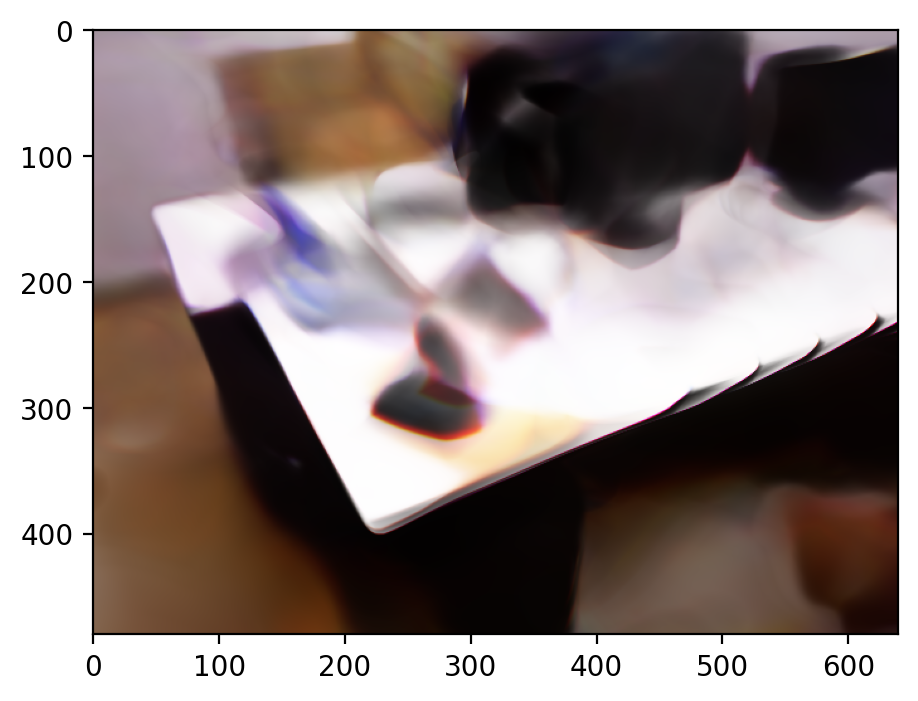

In [44]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

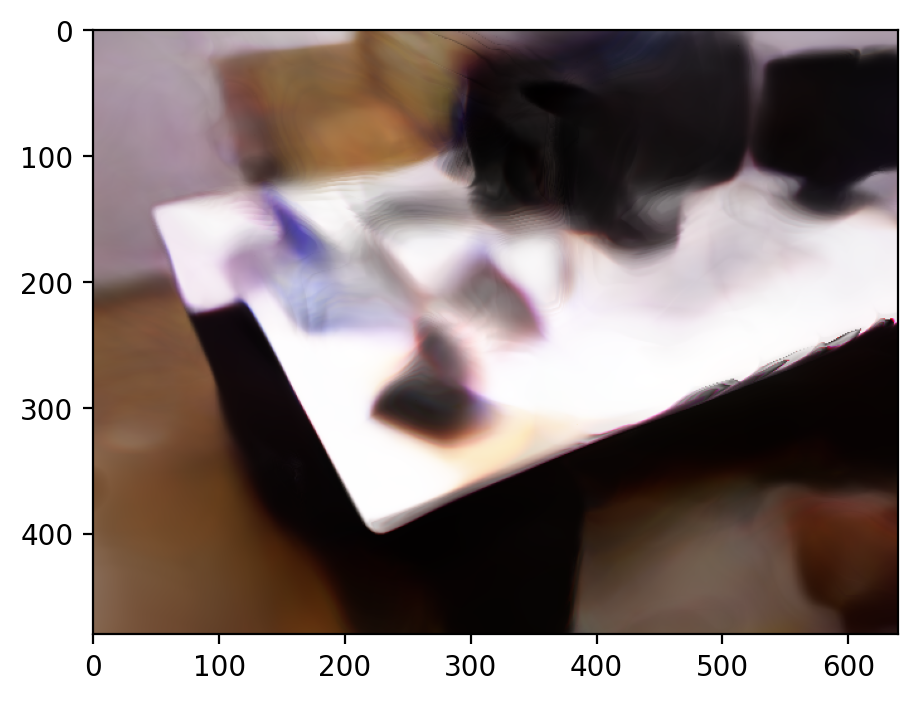

In [47]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

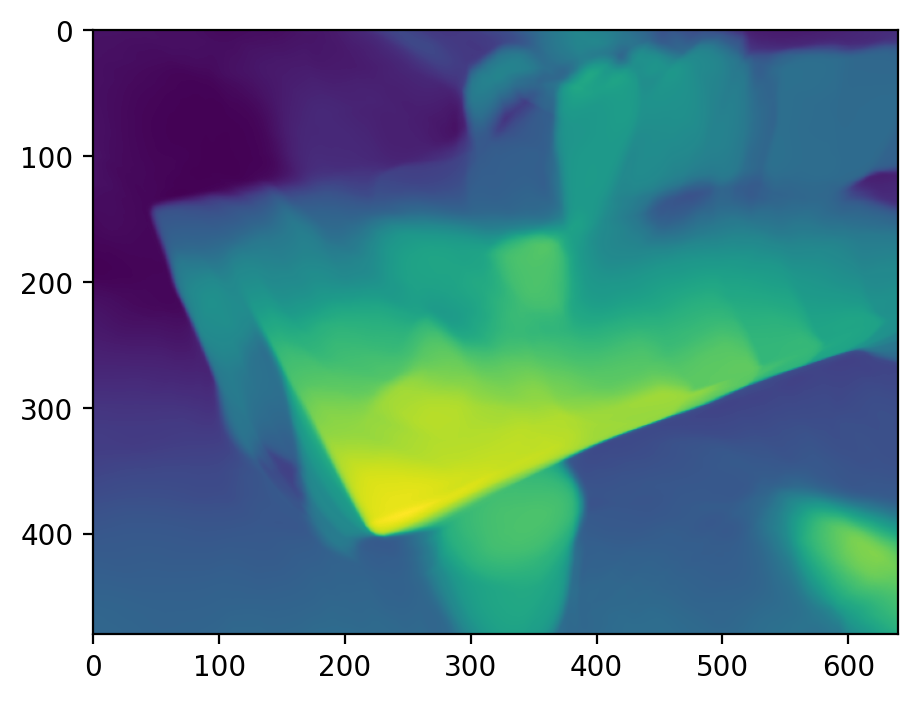

In [51]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

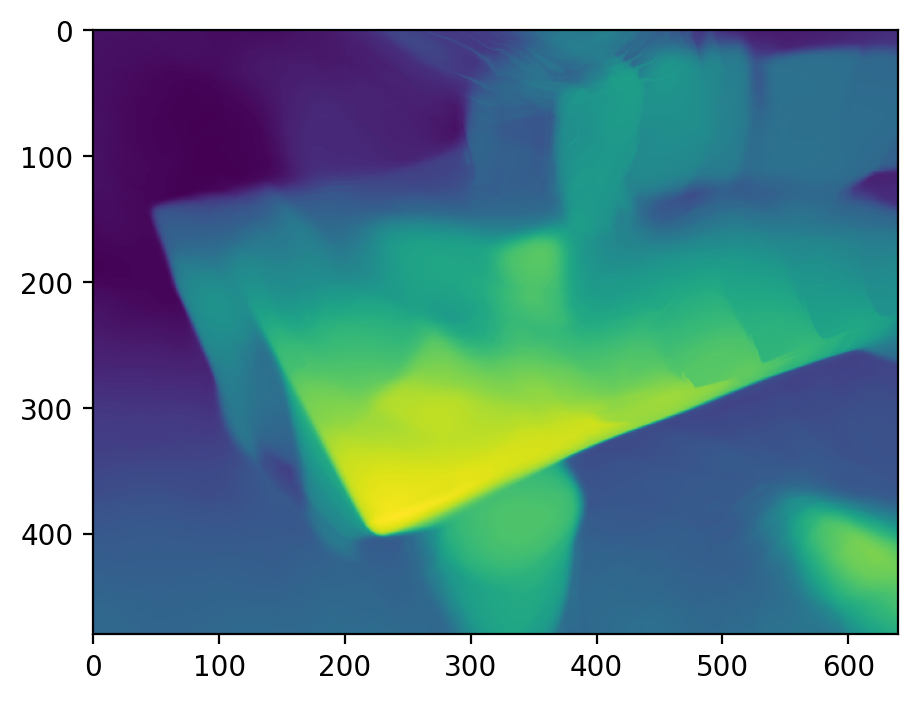

In [52]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

In [59]:
# model_classical_training.to('cuda')

NERF(
  (_mlp): MLP(
    (first_layer): Sequential(
      (0): Linear(in_features=93, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (last_layers): Sequential(
      (0): Linear(in_features=349, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (_positional_encoding): GaussianPositionalEncoding(
    (_b_encoding_matrix): Linear(in_features=3, out_features=93, bias=False)
  )
  (_loss): L1Loss()
)

In [22]:
batch_size = 4096
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []

eval_model = new_model.cuda()
eval_model.eval()

with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = eval_model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/75 [00:00<?, ?it/s]

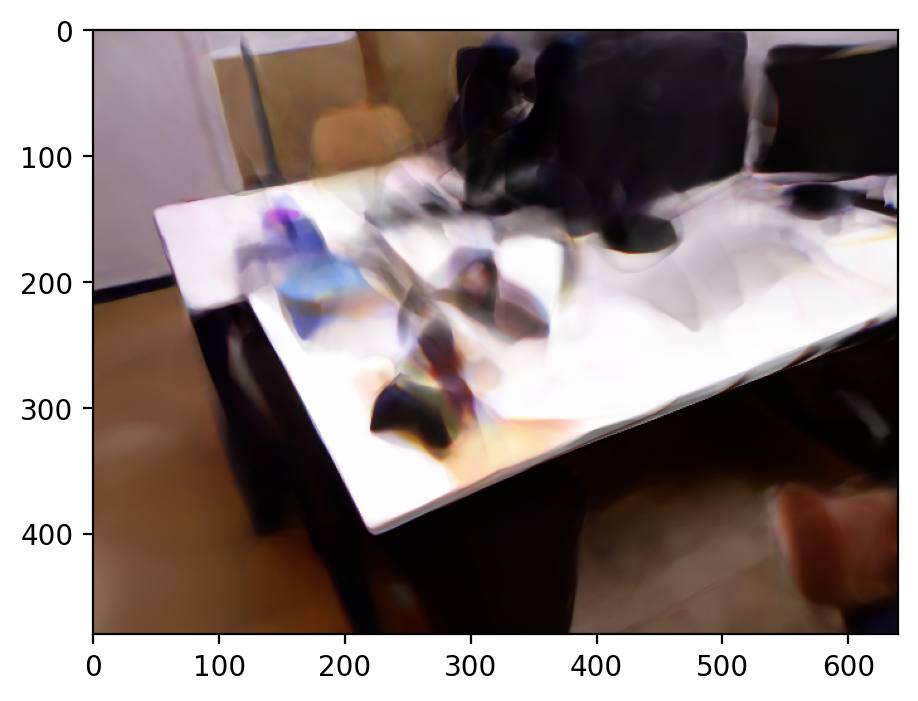

In [23]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

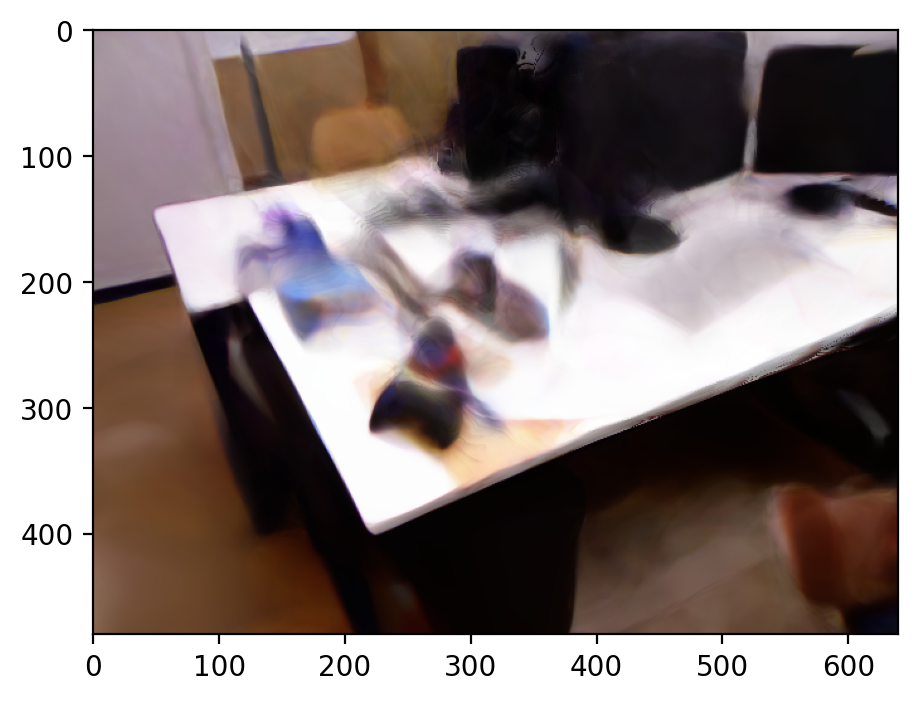

In [24]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480 // scale, 640 // scale, 3).detach().cpu().numpy()
mean = data_module.camera_info()._color_mean
std = data_module.camera_info()._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image.astype(np.float32), cv2.COLOR_RGB2BGR))

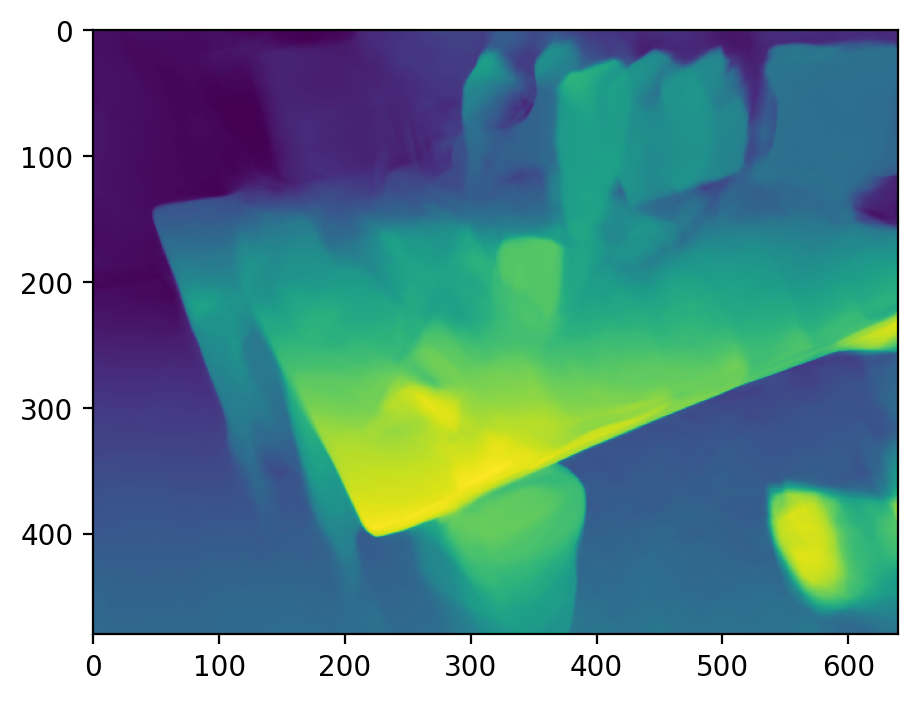

In [25]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

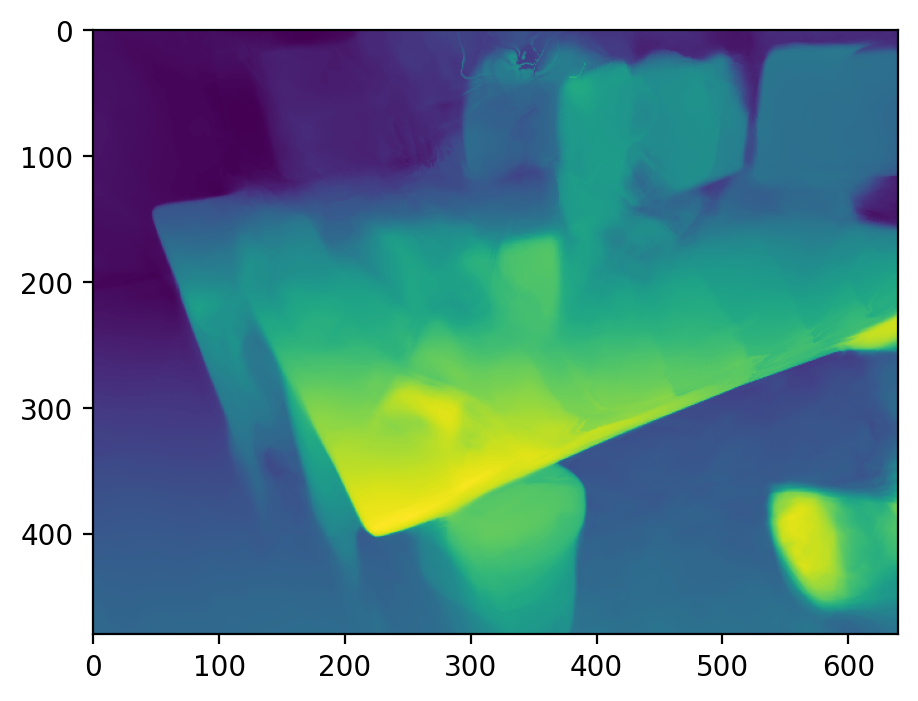

In [26]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(1. /reconstructed_depth)

# Test depth sampling

In [23]:
batch = None
for x in data_module.train_dataloader():
    batch = x
    break

In [24]:
image_index = 0
y = 304
x = 300
dataset_index = image_index * 480 * 640 + y * 640 + x
element = data_module._dataset[dataset_index]
pixel = torch.tensor(element['pixel']).cuda()[None]
camera_position = torch.tensor(element['camera_position']).cuda()[None]
truth_depth = torch.tensor(element['depth']).cuda()[None]

In [25]:
# pixel = batch['pixel'].cuda()
# camera_position = batch['camera_position'].cuda()
# truth_depth = batch['depth'].cuda()
course_sampled_depths = model.stratified_sample_depths(
    pixel.shape[0],
    pixel.device,
    model.hparams.course_sample_bins,
    False)
model = model.cuda()

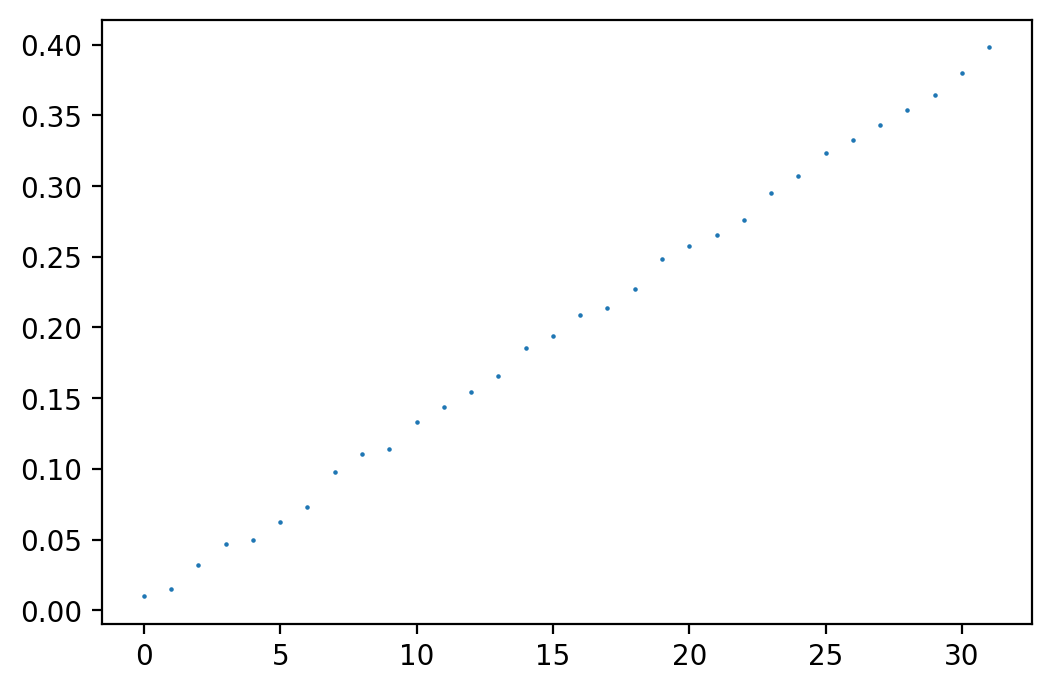

In [26]:
plt.figure(dpi=200)
plotted_depths = course_sampled_depths[:, 0].detach().cpu().numpy()
plt.scatter(np.arange(plotted_depths.shape[0]), plotted_depths, s=0.4)

In [27]:
course_color, course_depths, course_weights, course_depth_variance = model.reconstruct_color_and_depths(
    course_sampled_depths,
    pixel,
    camera_position,
    model._mlp)

In [28]:
bins_count = course_sampled_depths.shape[0]
sampled_depths = torch.sort(course_sampled_depths, dim=0).values
sampled_depths = course_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

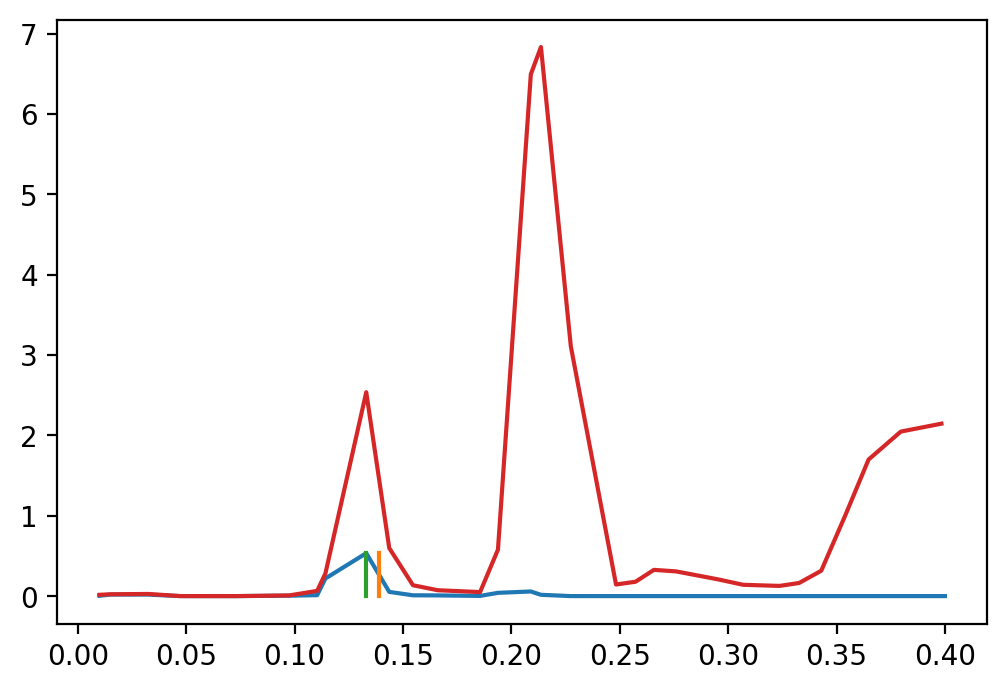

In [29]:
plt.figure(dpi=200)
index = 0
plotted_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_depths = np.append(plotted_depths, 0.4)
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
plotted_density = logsumexp_density[:, index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)
plt.plot(plotted_depths, plotted_weigths)
plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths)])
plt.plot(plotted_depths[:-1], plotted_density / 50.)

In [30]:
fine_sampled_depths = model.hierarchical_sample_depths(
    course_weights,
    pixel.shape[0],
    pixel.device,
    50,
    course_sampled_depths,
    False)

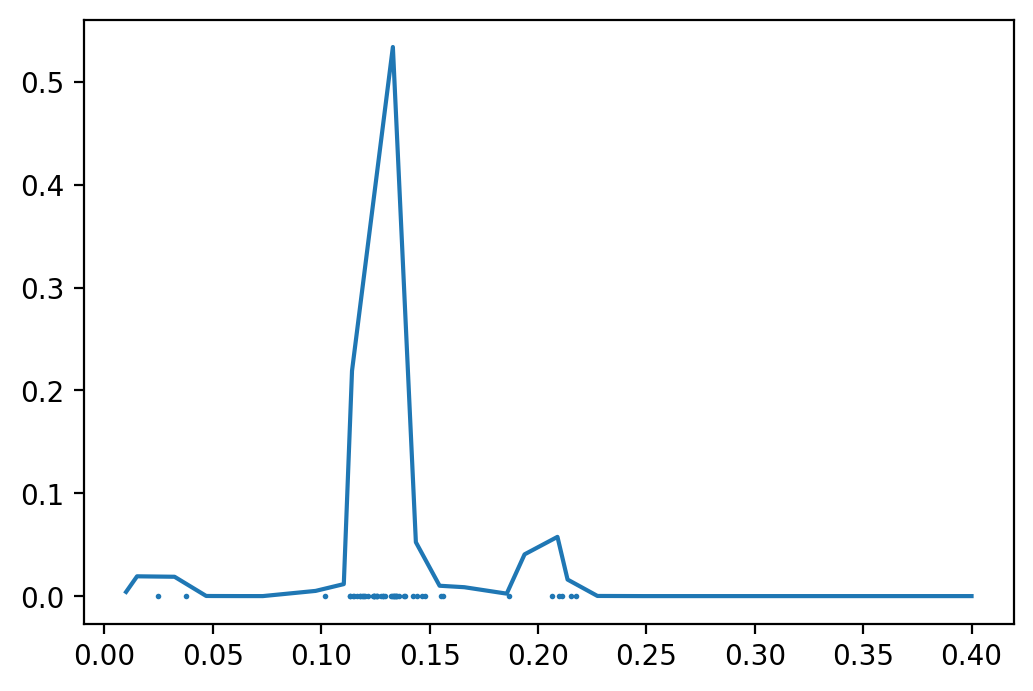

In [31]:
plt.figure(dpi=200)
index = 0
plotted_course_depths = course_sampled_depths[:, index].detach().cpu().numpy()
plotted_course_depths = np.append(plotted_course_depths, 0.4)
plotted_fine_depths = fine_sampled_depths[:, index].detach().cpu().numpy()
plotted_weigths = course_weights[:, index].detach().cpu().numpy()
plt.plot(plotted_course_depths, plotted_weigths)
plt.scatter(plotted_fine_depths, np.zeros_like(plotted_fine_depths), s=1)

In [32]:
with torch.no_grad():
    fine_color, fine_depths, fine_weights, fine_depth_variance = model.reconstruct_color_and_depths(
        fine_sampled_depths,
        pixel,
        camera_position,
        model._mlp)

In [33]:
bins_count = fine_sampled_depths.shape[0]
sampled_depths = torch.sort(fine_sampled_depths, dim=0).values
sampled_depths = fine_sampled_depths.reshape(-1)
pixels1 = model.repeat_tensor(pixel, bins_count)
camera_positions1 = model.repeat_tensor(camera_position, bins_count)
back_projected_points = back_project_pixel(pixels1, sampled_depths, camera_positions1,
                                           model._inverted_camera_matrix)
encodings = model._positional_encoding(back_projected_points)
prediction = model._mlp(encodings)

colors = prediction[:, :3].reshape(bins_count, -1, 3)
density = prediction[:, 3].reshape(bins_count, -1)

fine_logsumexp_density = torch.logsumexp(torch.cat([torch.zeros_like(density)[None], density[None]], dim=0), dim=0)

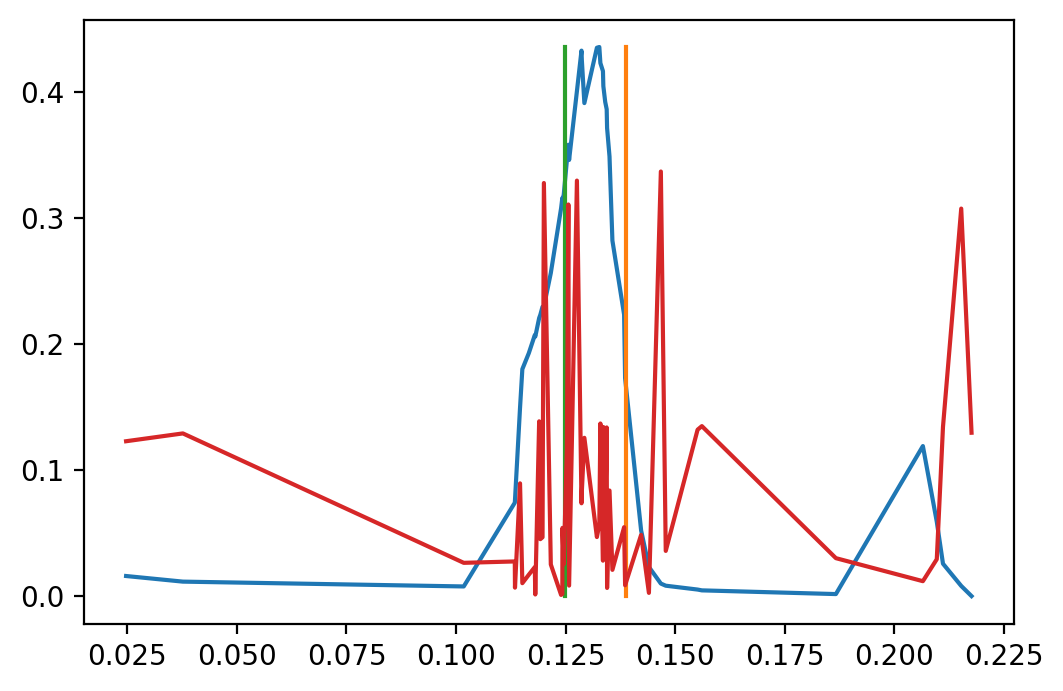

In [34]:
plt.figure(dpi=200)
index = 0
plotted_depths = torch.sort(fine_sampled_depths[:, index], dim=0).values.detach().cpu().numpy()
depth_deltas =  np.roll(plotted_depths, -1) - plotted_depths
plotted_weigths = fine_weights[:, index].detach().cpu().numpy()[:-1]
plotted_truth_depth = truth_depth[index].detach().cpu().numpy()
mean_depth = np.sum(plotted_depths * plotted_weigths)

plt.plot(plotted_depths, plotted_weigths / depth_deltas / 100)

plt.plot([plotted_truth_depth, plotted_truth_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])
plt.plot([mean_depth, mean_depth], [0, np.max(plotted_weigths / depth_deltas / 100)])

plotted_density = fine_logsumexp_density[:, index].detach().cpu().numpy()
plt.plot(plotted_depths, plotted_density / 1000)